In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
from src.dm import DataModule

dm = DataModule(batch_size=4)
dm.setup()

train: 8689
test: 2773


In [6]:
x, labels = next(iter(dm.train_dataloader()))

s1, s2 = x
s1.shape, s2.shape

(torch.Size([4, 12, 2, 256, 256]), torch.Size([4, 12, 3, 256, 256]))

In [4]:
from src.models.unet import UNet

hparams = {
    'encoder': 'resnet18',
    'pretrained': None,
    'in_channels': 5*12,
    'p': 0,
}

model = UNet(hparams)

_x, _ = model(x)

_x.shape

torch.Size([4, 256, 256])

In [6]:
import pytorch_lightning as pl

dm = DataModule(batch_size=4)

hparams = {
	'encoder': 'resnet18',
	'pretrained': 'imagenet',    
    'in_channels': 5*12,
	'optimizer': 'Adam',
	'p': 0,
	'optimizer_params': {
		'lr': 1e-3
	},
}

module = UNet(hparams)

trainer = pl.Trainer(
	gpus=1,
	precision=16,
	overfit_batches=1,
	max_epochs=1000,
	logger=None,
	enable_checkpointing=False,
)

trainer.fit(module, dm)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.


train: 8689
test: 2773


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type       | Params
------------------------------------------
0 | transforms | ModuleList | 0     
1 | unet       | Unet       | 14.5 M
------------------------------------------
14.5 M    Trainable params
0         Non-trainable params
14.5 M    Total params
29.014    Total estimated model params size (MB)
/home/juan/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:471: UserWarning: You requested to overfit but enabled training dataloader shuffling. We are turning off the training dataloader shuffling for you.
  rank_zero_warn(
/home/juan/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init

Training: 0it [00:00, ?it/s]

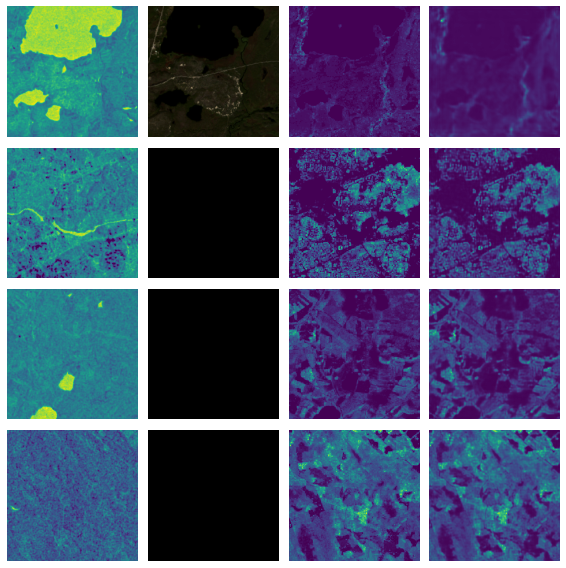

In [7]:
import matplotlib.pyplot as plt 

x, labels = next(iter(dm.train_dataloader(shuffle=False)))
s1s, s2s = x
preds = module.predict(x)
fig = plt.figure(figsize=(8, 2*dm.batch_size))
for i in range(dm.batch_size):
    ax = plt.subplot(dm.batch_size, 4, 4*i+1)
    ax.imshow(s1s[i][0][0])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+2)
    ax.imshow(s2s[i][0].permute(1, 2, 0))
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+3)
    ax.imshow(labels[i])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+4)
    ax.imshow(preds[i])
    ax.axis('off')
    # ax.set_title(torch.mean(torch.sqrt(
    #         torch.mean((preds * 12905.3 - labels * 12905.3)**2, dim=(1, 2)))).item())
plt.tight_layout()
plt.show()

In [12]:
from src.models.unet2 import UNet2

hparams = {
    'encoder': 'resnet18',
    'pretrained': None,
    'in_channels_s1': 2,
    'in_channels_s2': 3,
    'seq_len': 12,
    'p': 0,
}

model = UNet2(hparams)

_x, _ = model(x)

_x.shape

torch.Size([4, 256, 256])

In [13]:
import pytorch_lightning as pl

dm = DataModule(batch_size=4)

hparams = {
	'encoder': 'resnet18',
	'pretrained': 'imagenet',    
    'in_channels_s1': 2,
    'in_channels_s2': 3,
    'seq_len': 12,
	'optimizer': 'Adam',
	'p': 0,
	'optimizer_params': {
		'lr': 1e-3
	},
}

module = UNet2(hparams)

trainer = pl.Trainer(
	gpus=1,
	precision=16,
	overfit_batches=1,
	max_epochs=1000,
	logger=None,
	enable_checkpointing=False,
)

trainer.fit(module, dm)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.


train: 8689
test: 2773


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type       | Params
------------------------------------------
0 | transforms | ModuleList | 0     
1 | unet1      | Unet       | 14.3 M
2 | unet2      | Unet       | 14.3 M
3 | conv_out   | Conv2d     | 217   
------------------------------------------
28.7 M    Trainable params
0         Non-trainable params
28.7 M    Total params
57.307    Total estimated model params size (MB)
/home/juan/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:471: UserWarning: You requested to overfit but enabled training dataloader shuffling. We are turning off the training dataloader shuffling for you.
  rank_zero_warn(
/home/juan/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (tr

Training: 0it [00:00, ?it/s]

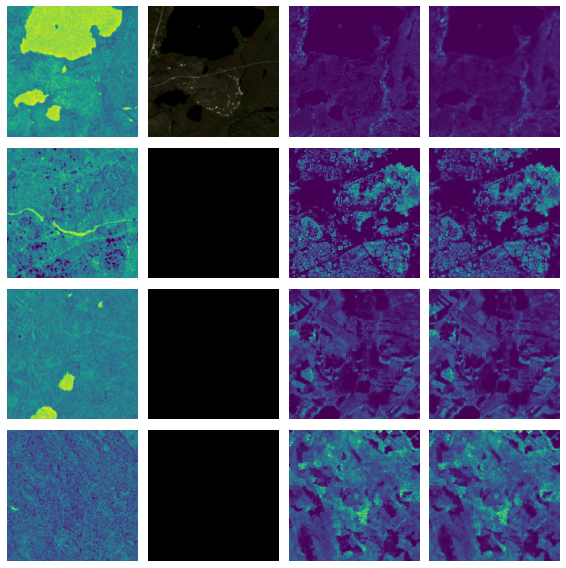

In [14]:
import matplotlib.pyplot as plt 

x, labels = next(iter(dm.train_dataloader(shuffle=False)))
s1s, s2s = x
preds = module.predict(x)
fig = plt.figure(figsize=(8, 2*dm.batch_size))
for i in range(dm.batch_size):
    ax = plt.subplot(dm.batch_size, 4, 4*i+1)
    ax.imshow(s1s[i][0][0])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+2)
    ax.imshow(s2s[i][0].permute(1, 2, 0))
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+3)
    ax.imshow(labels[i])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+4)
    ax.imshow(preds[i])
    ax.axis('off')
    # ax.set_title(torch.mean(torch.sqrt(
    #         torch.mean((preds * 12905.3 - labels * 12905.3)**2, dim=(1, 2)))).item())
plt.tight_layout()
plt.show()

In [15]:
from src.models.unet_df import UNetDF

hparams = {
    'encoder': 'resnet18',
    'pretrained': None,
    'in_channels_s1': 2,
    'in_channels_s2': 3,
    'seq_len': 12,
    'p': 0,
}

model = UNetDF(hparams)

_x, _ = model(x)

_x.shape

torch.Size([4, 256, 256])

In [16]:
import pytorch_lightning as pl

dm = DataModule(batch_size=4)

hparams = {
	'encoder': 'resnet18',
	'pretrained': 'imagenet',
	'in_channels_s1': 2,
	'in_channels_s2': 3,
	'optimizer': 'Adam',
	'p': 0,
    'seq_len': 12,
	'optimizer_params': {
		'lr': 1e-3
	},
}

module = UNetDF(hparams)

trainer = pl.Trainer(
	gpus=1,
	precision=16,
	overfit_batches=1,
	max_epochs=1000,
	logger=None,
	enable_checkpointing=False,
)

trainer.fit(module, dm)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name              | Type             | Params
-------------------------------------------------------
0 | transforms        | ModuleList       | 0     
1 | encoder1          | ResNetEncoder    | 11.2 M
2 | encoder2          | ResNetEncoder    | 11.2 M
3 | decoder           | UnetDecoder      | 48.5 M
4 | segmentation_head | SegmentationHead | 145   
-------------------------------------------------------
70.9 M    Trainable params
0         Non-trainable params
70.9 M    Total params
141.725   Total estimated model params size (MB)


train: 8689
test: 2773


/home/juan/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:471: UserWarning: You requested to overfit but enabled training dataloader shuffling. We are turning off the training dataloader shuffling for you.
  rank_zero_warn(
/home/juan/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

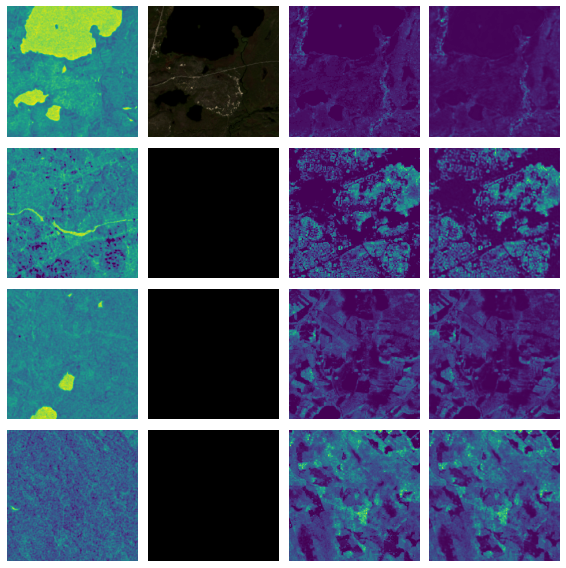

In [17]:
import matplotlib.pyplot as plt 

x, labels = next(iter(dm.train_dataloader(shuffle=False)))
s1s, s2s = x
preds = module.predict(x)
fig = plt.figure(figsize=(8, 2*dm.batch_size))
for i in range(dm.batch_size):
    ax = plt.subplot(dm.batch_size, 4, 4*i+1)
    ax.imshow(s1s[i][0][0])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+2)
    ax.imshow(s2s[i][0].permute(1, 2, 0))
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+3)
    ax.imshow(labels[i])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+4)
    ax.imshow(preds[i])
    ax.axis('off')
    # ax.set_title(torch.mean(torch.sqrt(
    #         torch.mean((preds * 12905.3 - labels * 12905.3)**2, dim=(1, 2)))).item())
plt.tight_layout()
plt.show()